# Business Understanding
The goal of this project is to build a model that accurately predicts the unit sales for items sold at different Favorita stores.


# Data Understanding
The dataset consist of 6 different files

1. train
2. test
3. transactions
4. stores
5. holidays_events
6. oil



# Data Preparation

In [110]:
#Importing libraries and dependencies
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
#from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from numpy import log
import matplotlib.pyplot as plt 
import seaborn as sns
import wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#pd.set_option('display.float_format', lambda x: '%.9f' % x)

In [2]:
# Loading the datasets into DataFrames
stores = pd.read_csv("stores.csv")
train = pd.read_csv("train.csv")
tests = pd.read_csv("test.csv")
transactions = pd.read_csv("transactions.csv")
holidays = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")

# Exploring the various dataset

In [3]:
#Exploring the train dataset
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
#Exploring the test dataset
tests.info()
tests.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


**Exploring the data shows that the train and test data have similar columns except the "sales" column which is not in the test data.**

In [5]:
#Checking for missing values
missing_values1 = train.isnull().sum().sort_values(ascending =True)
missing_values1

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

**Both train and test data have no missing values.
Let's explore the other datasets


In [6]:
#Exploring the transactions dataset
transactions.info()
transactions.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [7]:
#Exploring the Stores dataset
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


**The transaction and stores datasets have columns common to both test and train datasets. These columns can be used as a linking attribute (PK/FK) to merge the datasets on.**

In [8]:
#Checking for missing values
transactions_missing_values = transactions.isnull().sum().sort_values(ascending =True)
stores_missing_values = stores.isnull().sum().sort_values(ascending =True)
stores_missing_values,transactions_missing_values

(store_nbr    0
 city         0
 state        0
 type         0
 cluster      0
 dtype: int64,
 date            0
 store_nbr       0
 transactions    0
 dtype: int64)

**Both datasets have no missing values so we will go ahead and merge them with the train data. We will merge all 3 data set into a new dataFrame called df_train

In [9]:
#merging the 3 datasets
df_train = train.merge(transactions, on = ['date', 'store_nbr'], how='left')
df_train = df_train.merge(stores, on = 'store_nbr', how='left')
df_train.info()
df_train.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   transactions  float64
 7   city          object 
 8   state         object 
 9   type          object 
 10  cluster       int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 274.7+ MB


,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13


In [10]:
#Checking for missing values in our new dataset
missing_values2 = df_train.isnull().sum().sort_values(ascending =False)
missing_values2

transactions    245784
id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dtype: int64

**The transactions column is missing 245784 values** Since the column contains the count of sales transactions for each date, store_nbr combination, we have to fill the missing data as it is important for our analysis. 
**We will be using the back fill method because analysis of the data shows that the rows have repeating values. 

In [11]:
#Filling the missing data using the Backfill method
df_train["transactions"].fillna(method='bfill', inplace=True)
df_train

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,770.0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,770.0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,770.0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,770.0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,770.0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0,Quito,Pichincha,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Quito,Pichincha,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Quito,Pichincha,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Quito,Pichincha,B,6


** Let's disaggregate the date column into Year, Month and Day columns so we can aggregate the data by those parameters**

In [12]:
#Breaking the year column into day, month, year, day of the week, and week.
df_train['date'] = pd.to_datetime(train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['weekday'] = df_train['date'].dt.weekday
df_train['week'] = df_train['date'].dt.isocalendar().week
df_train['quarter'] = df_train['date'].dt.quarter
df_train['day_of_week'] = df_train['date'].dt.day_name()
df_train

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   transactions  float64       
 7   city          object        
 8   state         object        
 9   type          object        
 10  cluster       int64         
 11  year          int64         
 12  month         int64         
 13  day           int64         
 14  weekday       int64         
 15  week          UInt32        
 16  quarter       int64         
 17  day_of_week   object        
dtypes: UInt32(1), datetime64[ns](1), float64(2), int64(9), object(5)
memory usage: 426.4+ MB


In [14]:
#reseting dataframe index 
df_train.reset_index(drop=True, inplace=True)

# QUESTIONS

# 1. Is the train dataset complete (has all the required dates)?

# Checking for missing dates

In [15]:
#Checking for completeness of the dates
train.date.min(), train.date.max()
train['sales_date'] = pd.to_datetime(train['date']).dt.date
train['sales_date'].min(), train['sales_date'].max()

(datetime.date(2013, 1, 1), datetime.date(2017, 8, 15))

In [16]:
#expected number of days (max dates - min dates)

difference =(train['sales_date'].max() - train['sales_date'].min())
difference.days + 1


1688

In [17]:
#Actual number of days
train['sales_date'].nunique()


1684

In [18]:
#Missing dates
expected_dates = pd.date_range(start =train['sales_date'].min(), end= train['sales_date'].max())
set(expected_dates.date) - set(train['sales_date'].unique())

{datetime.date(2013, 12, 25),
 datetime.date(2014, 12, 25),
 datetime.date(2015, 12, 25),
 datetime.date(2016, 12, 25)}

From the result, the train dataset is mising 4 dates.These missing dates follow a sequence. All the years are missing dates of december 25th ( 12,25). This date is also a holiday in Ecuador. This analysis therfore assumes that no data was taken on this day every year as the shops may be closed down on that day each year. 

# 2. Which dates have the lowest and highest sales for each year?

<AxesSubplot:xlabel='year'>

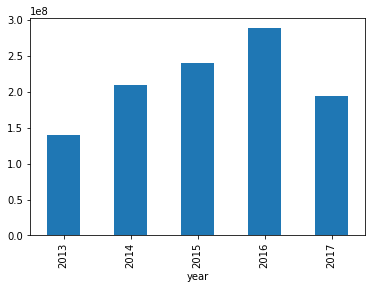

In [19]:
total_sales_by_year = df_train.groupby(['year'])['sales'].sum()
total_sales_by_year.plot.bar()


The Company recorded the highest sales in 2016, followed by 2015 and then 2014.The lowest sales was recorded in 2013 followed by 2017. However, the data for 2017 was collected for only 8 mont (2017/08/15) which may account for the ranking. Moreover, the trend shows yearly increase in sales which might make 2017 record the highest sales if the data for the rest of the months is added.

In [20]:
#Breaking the data into yearly set
sales_2013 =df_train.loc[df_train['year'] == 2013]
sales_2014 =df_train.loc[df_train['year'] == 2014]
sales_2015 =df_train.loc[df_train['year'] == 2015]
sales_2016 =df_train.loc[df_train['year'] == 2016]
sales_2017 =df_train.loc[df_train['year'] == 2017]
#Calculating minimum sales
min_2013 = int(sales_2013['sales'].min())
min_2014= int(sales_2014['sales'].min())
min_2015= int(sales_2015['sales'].min())
min_2016= int(sales_2016['sales'].min())
min_2017= int(sales_2017['sales'].min())
#Calculating maximum sales
max_2013= int(sales_2013['sales'].max())
max_2014= int(sales_2014['sales'].max())
max_2015= float(sales_2015['sales'].max())
max_2016= int(sales_2016['sales'].max())
max_2017= float(sales_2017['sales'].max())
max_2013,max_2014,max_2015,max_2016,max_2017

(46271, 45361, 40351.46, 124717, 38422.625)

In [21]:
#Max value and date for 2013
sales_2013.loc[sales_2013['sales'] == max_2013]

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
562596,562596,2013-11-12,44,GROCERY I,46271.0,0,3577.0,Quito,Pichincha,A,5,2013,11,12,1,46,4,Tuesday


In [22]:
#Max value and date for 2014
sales_2014.loc[sales_2014['sales'] == max_2014]

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
1257246,1257246,2014-12-08,35,GROCERY I,45361.0,3,624.0,Playas,Guayas,C,3,2014,12,8,0,50,4,Monday


In [23]:
#Max value and date for 2015
sales_2015.loc[sales_2015['sales'] == max_2015]

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
1916586,1916586,2015-12-14,35,GROCERY I,40351.46,7,594.0,Playas,Guayas,C,3,2015,12,14,0,51,4,Monday


In [24]:
#Max value and date for 2016
sales_2016.loc[sales_2016['sales'] == max_2016]

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
2163723,2163723,2016-05-02,2,GROCERY I,124717.0,59,1905.0,Quito,Pichincha,D,13,2016,5,2,0,18,2,Monday


In [25]:
#Max value and date for 2017
sales_2017.loc[sales_2017['sales'] == max_2017]

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
2760297,2760297,2017-04-02,9,GROCERY I,38422.625,73,2245.0,Quito,Pichincha,B,6,2017,4,2,6,13,2,Sunday


The dates and maximum values for the years are
YEAR     DATE       AMOUNT
2013  2013-11-12     46271
2014  2014-12-08	 45361
2015  2015-12-14     40351.46
2016  2016-05-02	 124717
2017  2017-04-02     124717

# 3. Did the earthquake impact sales?

Since the earthquake struck Ecuador on April 16, 2016, lets explore the 2016 data

day
1     1.004172e+07
2     1.130189e+07
3     1.117659e+07
4     1.040226e+07
5     9.910870e+06
6     1.009564e+07
7     9.156555e+06
8     8.573419e+06
9     9.493922e+06
10    9.537904e+06
11    9.016023e+06
12    8.936502e+06
13    8.954708e+06
14    8.426829e+06
15    8.825597e+06
16    9.801118e+06
17    9.988999e+06
18    9.864747e+06
19    9.374226e+06
20    1.001174e+07
21    9.597905e+06
22    9.100030e+06
23    9.745349e+06
24    9.499665e+06
25    7.579952e+06
26    8.790574e+06
27    9.078644e+06
28    8.512522e+06
29    8.552453e+06
30    9.127977e+06
31    6.178197e+06
Name: sales, dtype: float64

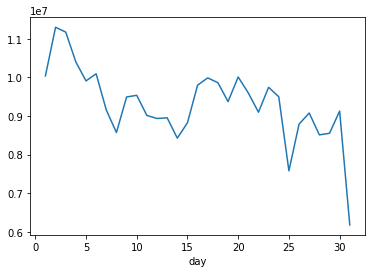

In [26]:
total_sale = sales_2016.groupby(["day"])['sales'].sum()

total_sale.plot()
total_sale

day
1     7.715082e+06
2     8.212901e+06
3     7.410473e+06
4     7.837522e+06
5     7.476711e+06
6     6.694271e+06
7     7.044224e+06
8     6.905308e+06
9     6.519628e+06
10    6.223471e+06
11    6.877406e+06
12    6.716819e+06
13    6.396314e+06
14    6.302049e+06
15    6.850851e+06
16    5.898453e+06
17    5.853783e+06
18    5.925920e+06
19    5.691621e+06
20    5.498339e+06
21    6.083462e+06
22    5.952142e+06
23    5.793121e+06
24    5.606596e+06
25    5.953790e+06
26    5.715473e+06
27    5.150372e+06
28    6.056566e+06
29    5.408016e+06
30    5.045494e+06
31    3.400891e+06
Name: sales, dtype: float64

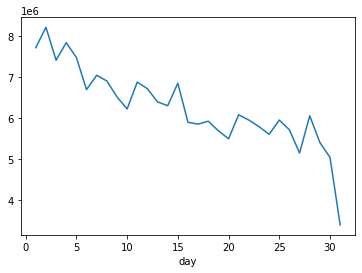

In [27]:
total_sale = sales_2017.groupby(['day'])['sales'].sum()
#total_sale = total_sale.sort_index()
#total_sale.plot(x=total_sale.index, y=total_sale.values, ylabel= 'Funding Amount in Dollars',xlabel='Funding Year')
total_sale.plot()
#plt.show()
#earth__quake =df_train.loc[df_train['date'] == '2016-04-17']
#earth__quake
#April 16, 2016
#total_sale.plot.bar()
total_sale

<AxesSubplot:xlabel='day'>

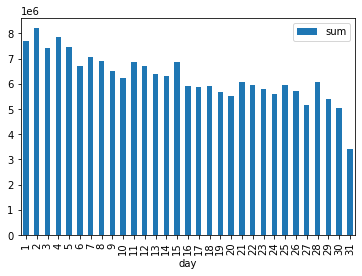

In [28]:
total_sal = sales_2017.groupby(['day'])['sales'].agg(["sum"])
#total_sales = df_train.groupby(['year'])['sales'].sum()
#total_sales = df_train.groupby(['year'].as_index=False)['sales'].sum()
#total_sales1 = total_sales.sort_index()
total_sal.plot.bar()


,sum
month,
1,2.397780e+07
2,2.194741e+07
3,2.313178e+07
4,2.596303e+07
5,2.477943e+07
6,2.220922e+07
7,2.346267e+07
8,2.245241e+07
9,2.241745e+07


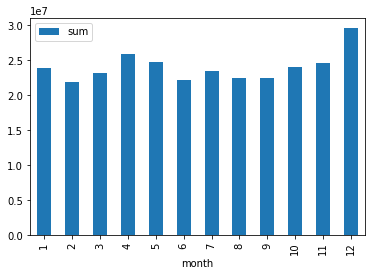

In [29]:
total_sal = sales_2016.groupby(['month'])['sales'].agg(["sum"])
#total_sales = df_train.groupby(['year'])['sales'].sum()
#total_sales = df_train.groupby(['year'].as_index=False)['sales'].sum()
#total_sales1 = total_sales.sort_index()
total_sal.plot.bar()
total_sal

,sum
month,
1,2.632816e+07
2,2.325011e+07
3,2.670402e+07
4,2.589531e+07
5,2.691185e+07
6,2.568282e+07
7,2.701148e+07
8,1.243332e+07


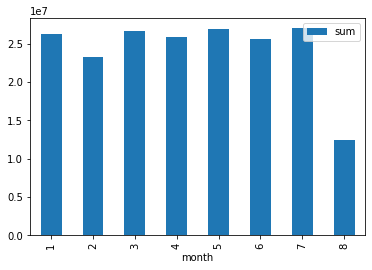

In [30]:
total_sal = sales_2017.groupby(['month'])['sales'].agg(["sum"])
#total_sales = df_train.groupby(['year'])['sales'].sum()
#total_sales = df_train.groupby(['year'].as_index=False)['sales'].sum()
#total_sales1 = total_sales.sort_index()
total_sal.plot.bar()
total_sal

From the analysis, there was no clear evidence of the effect(positive or negative) of the earth quick on sales. Sales in the month of the earthquake(APRIL)was within the yearly average for that month. Sales for the month after the earthquake was also within the yearly average.

# 4.  Are certain groups of stores selling more products? (Cluster, city, state, type)

In [31]:
num_stores = df_train['store_nbr'].nunique()
num_city = df_train['city'].nunique()
num_state = df_train['state'].nunique()
num_family = df_train['family'].nunique()
num_cluster = df_train['cluster'].nunique()
num_type = df_train['type'].nunique()
num_stores,num_city,num_state,num_cluster,num_family,num_type

(54, 22, 16, 17, 33, 5)

There are 54 stores located in 22 cities across 16 states selling 17 group of items. The stores are grouped into 33 clusters and 5 types.

store_nbr
52    2.696170e+06
22    4.090202e+06
32    5.951796e+06
30    7.382074e+06
35    7.676679e+06
26    7.755122e+06
42    8.945768e+06
21    9.255506e+06
10    9.613906e+06
29    9.725158e+06
13    1.052305e+07
12    1.065922e+07
16    1.098641e+07
54    1.105748e+07
53    1.121617e+07
14    1.138792e+07
25    1.142100e+07
15    1.145127e+07
23    1.165138e+07
20    1.292095e+07
19    1.304951e+07
18    1.325938e+07
1     1.414501e+07
33    1.417850e+07
41    1.499104e+07
36    1.532243e+07
5     1.559240e+07
43    1.639169e+07
34    1.709073e+07
31    1.774687e+07
17    1.803097e+07
28    1.838315e+07
40    1.839576e+07
38    1.886000e+07
4     1.890970e+07
27    1.918802e+07
37    1.997064e+07
39    2.025219e+07
2     2.155739e+07
24    2.376773e+07
6     2.518368e+07
9     2.640944e+07
7     2.695205e+07
11    2.832556e+07
50    2.865302e+07
8     3.049429e+07
51    3.291149e+07
48    3.593313e+07
46    4.189606e+07
49    4.342010e+07
3     5.048191e+07
47    5.094831e+07
45

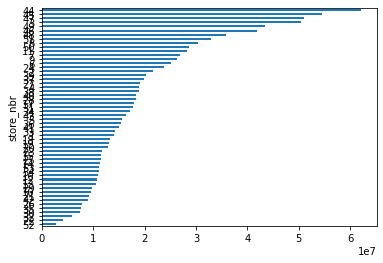

In [32]:
#Sales by store 
total_sales_store = df_train.groupby(['store_nbr'])['sales'].sum()
total_sales_store = total_sales_store.sort_values()
total_sales_store.plot.barh()

total_sales_store

<AxesSubplot:ylabel='city'>

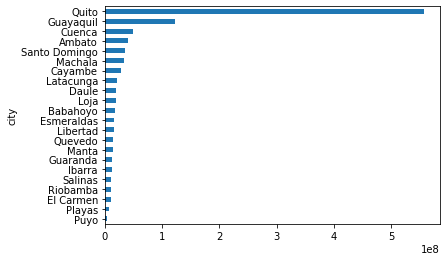

In [33]:
#Sales by city
total_sales_city = df_train.groupby(['city'])['sales'].sum()
total_sales_city = total_sales_city.sort_values()
total_sales_city.plot.barh()

#total_sales_city

**Quito is the city with the highest sales of $556,741,836.83**

state
Pastaza                           4.090202e+06
Chimborazo                        1.138792e+07
Santa Elena                       1.142100e+07
Imbabura                          1.145127e+07
Bolivar                           1.304951e+07
Esmeraldas                        1.639169e+07
Loja                              1.886000e+07
Cotopaxi                          2.118226e+07
Manabi                            2.496982e+07
Los Rios                          3.192537e+07
El Oro                            3.338680e+07
Santo Domingo de los Tsachilas    3.583432e+07
Tungurahua                        4.030440e+07
Azuay                             4.916860e+07
Guayas                            1.651544e+08
Pichincha                         5.850674e+08
Name: sales, dtype: float64

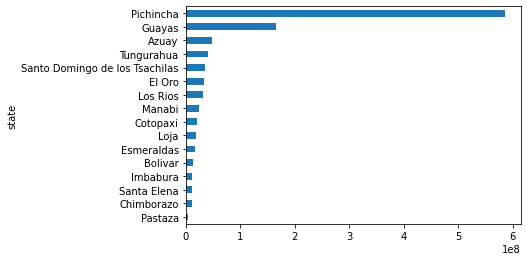

In [34]:
#Sales by State
total_sales_state = df_train.groupby(['state'])['sales'].sum()
total_sales_state = total_sales_state.sort_values()
total_sales_state.plot.barh()

total_sales_state

cluster
16    1.325938e+07
7     1.547812e+07
12    1.803097e+07
2     2.891640e+07
9     3.056108e+07
17    3.291149e+07
4     4.944344e+07
1     5.437675e+07
15    5.529695e+07
5     6.208755e+07
13    7.210225e+07
3     7.562870e+07
10    8.532443e+07
11    1.006143e+08
8     1.079282e+08
6     1.142544e+08
14    1.574305e+08
Name: sales, dtype: float64

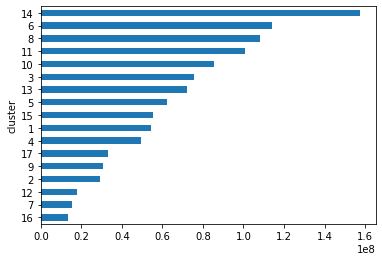

In [35]:
#Sales by store cluster
total_sales_cluster = df_train.groupby(['cluster'])['sales'].sum()
total_sales_cluster = total_sales_cluster.sort_values()
total_sales_cluster.plot.barh()

total_sales_cluster

type
E    5.982244e+07
B    1.452606e+08
C    1.644347e+08
D    3.510833e+08
A    3.530438e+08
Name: sales, dtype: float64

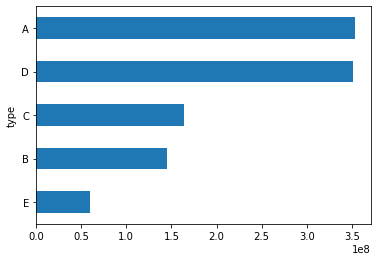

In [36]:
#Sales by store type
total_sales_store = df_train.groupby(['type'])['sales'].sum()
total_sales_store = total_sales_store.sort_values()
total_sales_store.plot.barh()

total_sales_store

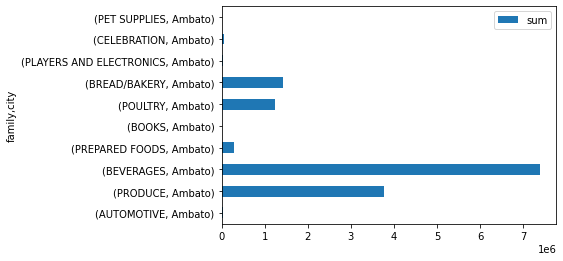

,,sum
family,city,
AUTOMOTIVE,Ambato,2.345300e+04
PRODUCE,Ambato,3.760752e+06
BEVERAGES,Ambato,7.402705e+06
PREPARED FOODS,Ambato,2.902157e+05
BOOKS,Ambato,3.790000e+02
...,...,...
HOME CARE,Santo Domingo,7.071960e+05
PRODUCE,Santo Domingo,3.238346e+06
GROCERY I,Santo Domingo,1.273277e+07


In [37]:
total_sales = df_train.groupby(['family','city'])['sales'].agg(["sum"])
total_sales = total_sales.sort_values('city')
total_sales.head(10).plot.barh()
plt.show()
total_sales

,,sum
family,city,
AUTOMOTIVE,Ambato,2.345300e+04
PRODUCE,Ambato,3.760752e+06
BEVERAGES,Ambato,7.402705e+06
PREPARED FOODS,Ambato,2.902157e+05
BOOKS,Ambato,3.790000e+02
...,...,...
HOME CARE,Santo Domingo,7.071960e+05
PRODUCE,Santo Domingo,3.238346e+06
GROCERY I,Santo Domingo,1.273277e+07


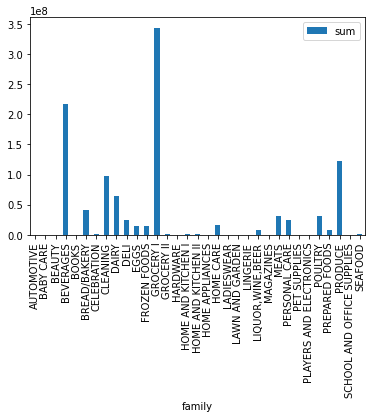

In [38]:
#Sales by product family
total_sales_family = df_train.groupby(['family'])['sales'].agg(["sum"])
total_sales_family = total_sales_family.sort_values('family')
total_sales_family.plot.bar()

total_sales

# 4. Are sales affected by promotions, oil prices and holidays?

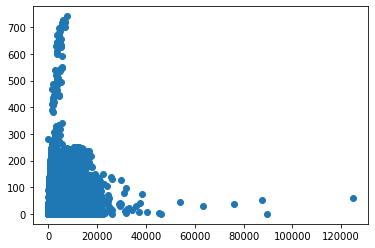

In [39]:
x1=df_train['sales'] 
y1=df_train['onpromotion']
plt.scatter(x1,y1)

<AxesSubplot:>

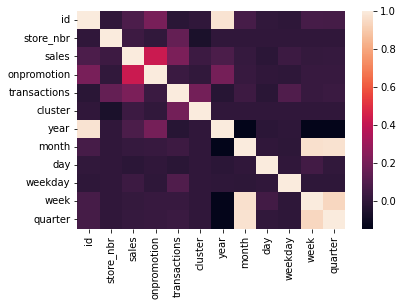

In [40]:

sns.heatmap(df_train.corr())


# 5. What analysis can we get from the date and its extractable features?

<AxesSubplot:xlabel='date'>

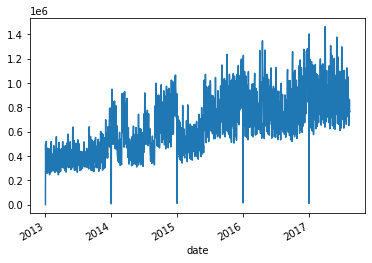

In [41]:
#Sales by year
total_sales = df_train.groupby(['date'])['sales'].sum()
total_sales.plot()


(sum    1.404190e+08
 dtype: float64,
 sum    2.886545e+08
 dtype: float64)

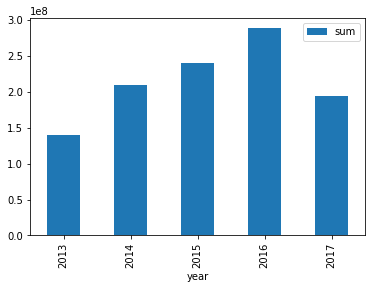

In [42]:
#Total sales by Year
total_sales = df_train.groupby(['year'])['sales'].agg(["sum"])
total_sales.plot.bar()
total_sales.min(),total_sales.max()
#total_sales

,sum
month,
1,9.444215e+07
2,8.063723e+07
3,9.722849e+07
4,9.066812e+07
5,9.439914e+07
6,9.451670e+07
7,1.033631e+08
8,8.347238e+07
9,7.747368e+07


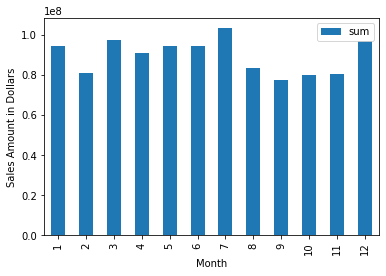

In [43]:
#Sales by Month
total_sales_bydate = df_train.groupby(['month'])['sales'].agg(["sum"])
total_sales_bydate.plot.bar(ylabel= 'Sales Amount in Dollars',xlabel='Month')
total_sales_bydate

<AxesSubplot:xlabel='day_of_week'>

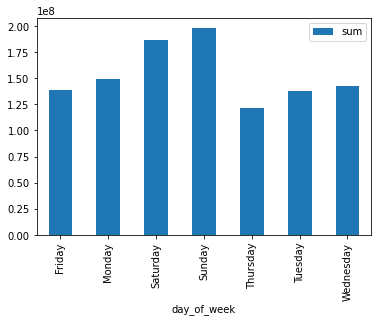

In [44]:

total_sales_byday = df_train.groupby(['day_of_week'])['sales'].agg(["sum"])
#total_sales_byday = df_train.groupby(['sales'])['day_of_week'].agg(["sum"])
total_sales_byday = total_sales_byday.sort_index(axis =0)
total_sales_byday.plot.bar()
#(x=total_investment.index, y=total_investment.values, 
                        #  ylabel= 'Funding Amount in Dollars',xlabel='Funding Year')


,mean
year,
2013,216.479530
2014,322.939786
2015,371.357193
2016,443.790297
2017,480.124466


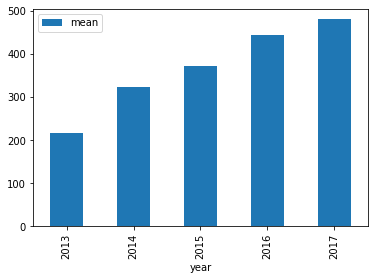

In [45]:
total_sales = df_train.groupby(['year'])['sales'].agg(["mean"])
total_sales.plot.bar()
total_sales

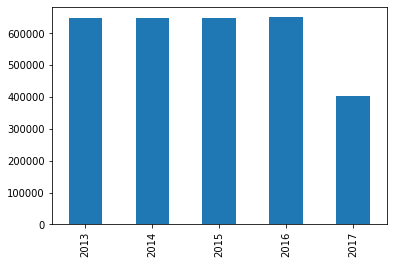

2013    648648
2014    648648
2015    648648
2016    650430
2017    404514
Name: year, dtype: int64

In [46]:
#volume of sales transaction/ number of sales transactions by year
sales_count = df_train["year"].value_counts(sort=False)
#tran_count = transactions["transactions"].value_counts(sort=False)
sales_count.plot.bar()
plt.show()
sales_count
#tran_count

The number of individuals sales are the same for all years except 2017 which is less than the rest of the years. Further analysis reveled that , the data for 2017 was collected between 1st january and August 15. This may account for the year having less number of sales transactions than the other years.

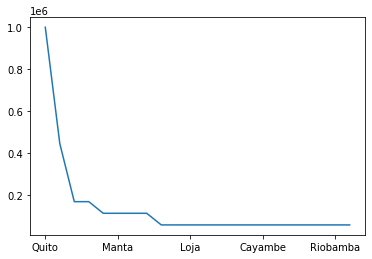

Quito            1000296
Guayaquil         444576
Santo Domingo     166716
Cuenca            166716
Latacunga         111144
Manta             111144
Machala           111144
Ambato            111144
Quevedo            55572
Esmeraldas         55572
Loja               55572
Libertad           55572
Playas             55572
Daule              55572
Babahoyo           55572
Cayambe            55572
Salinas            55572
Puyo               55572
Guaranda           55572
Ibarra             55572
Riobamba           55572
El Carmen          55572
Name: city, dtype: int64

In [47]:
#volume of transaction/ number of transactions by year
#sales_count = df_train.groupby(['city'])['store_nbr'].value_counts()
sales_count = df_train['city'].value_counts()
#sales_count = df_train["year"].value_counts(sort=False)
#sales_count.plot.line(x=sales_counts.index, y=sales_counts.values)
sales_count.plot.line()
plt.show()
sales_count

,sum
state,
Azuay,4.916860e+07
Bolivar,1.304951e+07
Chimborazo,1.138792e+07
Cotopaxi,2.118226e+07
El Oro,3.338680e+07
Esmeraldas,1.639169e+07
Guayas,1.651544e+08
Imbabura,1.145127e+07
Loja,1.886000e+07


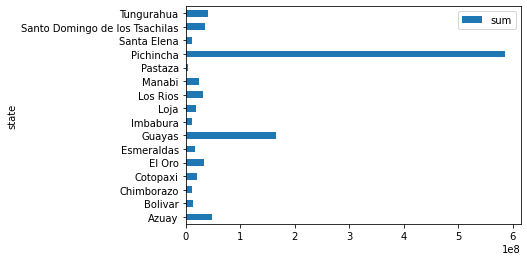

In [48]:
#Sales by state
total_sales_state = df_train.groupby(['state'])['sales'].agg(["sum"])

total_sales_state = total_sales_state.sort_index()
total_sales_state.head(20).plot.barh()

total_sales_state

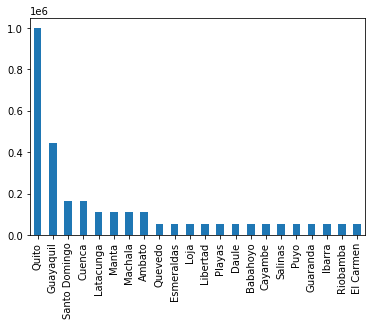

Quito            1000296
Guayaquil         444576
Santo Domingo     166716
Cuenca            166716
Latacunga         111144
Manta             111144
Machala           111144
Ambato            111144
Quevedo            55572
Esmeraldas         55572
Loja               55572
Libertad           55572
Playas             55572
Daule              55572
Babahoyo           55572
Cayambe            55572
Salinas            55572
Puyo               55572
Guaranda           55572
Ibarra             55572
Riobamba           55572
El Carmen          55572
Name: city, dtype: int64

In [49]:
#volume of transaction/ number of transactions by year
#sales_count = df_train.groupby(['city'])['store_nbr'].value_counts()
sales_count = df_train['city'].value_counts()
#sales_count = df_train["year"].value_counts(sort=False)
#sales_count.plot.line(x=sales_counts.index, y=sales_counts.values)
sales_count.plot.bar()
plt.show()
sales_count

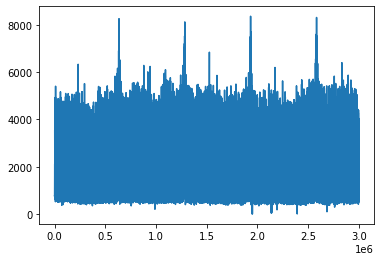

In [50]:
z = df_train['transactions']
z.plot()
plt.show()


In [51]:
missing_values = df_train.isnull().sum().sort_values(ascending =True)
missing_values

id              0
week            0
weekday         0
day             0
month           0
year            0
cluster         0
type            0
state           0
city            0
transactions    0
onpromotion     0
sales           0
family          0
store_nbr       0
date            0
quarter         0
day_of_week     0
dtype: int64

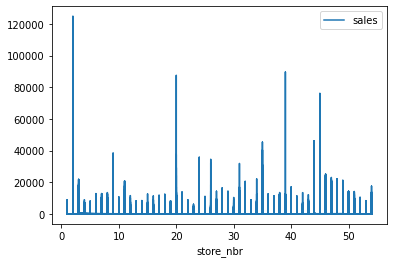

In [52]:
train.plot(x="store_nbr", y="sales")
plt.show()

In [53]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,sales_date
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01
2,2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01
4,4,2013-01-01,1,BOOKS,0.0,0,2013-01-01


In [54]:
#merging the 5 datasets
df_train1 = train.merge(transactions, on = ['date', 'store_nbr'], how='left')
df_train1 = df_train1.merge(stores, on = 'store_nbr', how='left')
df_train1 = df_train1.merge(oil, on = 'date', how='left')
df_train1 = train.merge(holidays, on = 'date', how='left')
#df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})
df_train1.head()


,id,date,store_nbr,family,sales,onpromotion,sales_date,type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False


In [55]:
#Breaking the year column into day, month, year, day of the week, and week so we can aggregate the data by those parameters
df_train1['date'] = pd.to_datetime(df_train1['date'])
df_train1['year'] = df_train1['date'].dt.year
df_train1['month'] = df_train1['date'].dt.month
df_train1['week'] = df_train1['date'].dt.isocalendar().week
df_train1['quarter'] = df_train1['date'].dt.quarter
df_train1['day_of_week'] = df_train1['date'].dt.day_name()
df_train1[:2]

,id,date,store_nbr,family,sales,onpromotion,sales_date,type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


In [56]:
a = df_train1["year"].value_counts(sort=False)
a
#plt.show()

2013    657558
2014    659340
2015    655776
2016    670032
2017    411642
Name: year, dtype: int64

In [57]:
#b = df_train1["store_nbr"].unique()
b= stores["city"].value_counts(sort=False)
#b = stores["city"].unique()
b


Quito            18
Santo Domingo     3
Cayambe           1
Latacunga         2
Riobamba          1
Ibarra            1
Guaranda          1
Puyo              1
Ambato            2
Guayaquil         8
Salinas           1
Daule             1
Babahoyo          1
Quevedo           1
Playas            1
Libertad          1
Cuenca            3
Loja              1
Machala           2
Esmeraldas        1
Manta             2
El Carmen         1
Name: city, dtype: int64

In [58]:
missing_values = df_train1.isnull().sum().sort_values(ascending =True)
missing_values

id                   0
week                 0
month                0
year                 0
quarter              0
sales_date           0
day_of_week          0
sales                0
family               0
store_nbr            0
date                 0
onpromotion          0
type           2551824
locale_name    2551824
description    2551824
transferred    2551824
locale         2551824
dtype: int64

In [59]:
#merging the 5 dataset
dfs = train
df1 = dfs.merge(holidays, on = 'date', how='left')
df1 = df1.merge(stores, on = 'store_nbr', how='left')
df1


,id,date,store_nbr,family,sales,onpromotion,sales_date,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.000,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.000,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.000,0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6


In [60]:
missing_values = df1.isnull().sum().sort_values(ascending =True)
missing_values.head(20)

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
sales_date           0
city                 0
state                0
type_y               0
cluster              0
type_x         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

In [61]:
#Lets have a look at the missing data in the sector column 
nan_values = df1[df1['sales'].isna()]
nan_values

,id,date,store_nbr,family,sales,onpromotion,sales_date,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster


In [62]:
#Max value and date for 2016
df1.loc[df1['sales'] == "2017-01-15"]

,id,date,store_nbr,family,sales,onpromotion,sales_date,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster


In [63]:
# Dropping missing values
df1.dropna(inplace=True)
df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 502524 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           502524 non-null  int64  
 1   date         502524 non-null  object 
 2   store_nbr    502524 non-null  int64  
 3   family       502524 non-null  object 
 4   sales        502524 non-null  float64
 5   onpromotion  502524 non-null  int64  
 6   sales_date   502524 non-null  object 
 7   type_x       502524 non-null  object 
 8   locale       502524 non-null  object 
 9   locale_name  502524 non-null  object 
 10  description  502524 non-null  object 
 11  transferred  502524 non-null  object 
 12  city         502524 non-null  object 
 13  state        502524 non-null  object 
 14  type_y       502524 non-null  object 
 15  cluster      502524 non-null  int64  
dtypes: float64(1), int64(4), object(11)
memory usage: 65.2+ MB


,sum
type_x,
Additional,3.302028e+07
Bridge,2.388330e+06
Event,4.247747e+07
Holiday,1.092227e+08
Transfer,7.501824e+06
Work Day,3.315924e+06


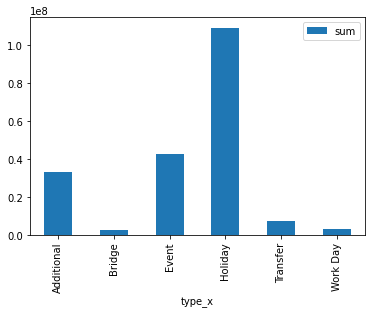

In [64]:
tota = df1.groupby(['type_x'])['sales'].agg(["sum"])
#total_sales2 = total_sales2.sort_index()
tota.plot.bar()
#(x=total_investment.index, y=total_investment.values, 
                        #  ylabel= 'Funding Amount in Dollars',xlabel='Funding Year')
tota

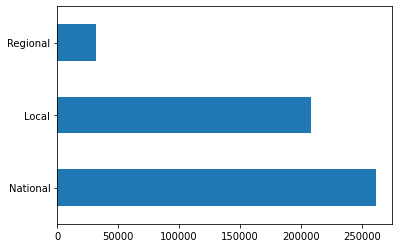

In [65]:
b= df1["locale"].value_counts(sort=True)
b.plot.barh()
plt.show()

In [66]:
missing_values = df1.isnull().sum().sort_values(ascending =True)
missing_values

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
sales_date     0
type_x         0
locale         0
locale_name    0
description    0
transferred    0
city           0
state          0
type_y         0
cluster        0
dtype: int64

In [67]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [68]:
#Checking for completeness of the dates
train.date.min(), train.date.max()
train['sales_date'] = pd.to_datetime(train['date']).dt.date
train['sales_date'].min(), train['sales_date'].max()
#expected number of days
#difference =(train['sales_date'].max - train['sales_date'].min())
difference =(train['sales_date'].max() - train['sales_date'].min())
difference.days + 1

1688

In [69]:
train['sales_date'].max()

datetime.date(2017, 8, 15)

In [70]:
#Actual number of days
train['sales_date'].nunique()

1684

In [71]:
#Missing dates
expected_dates = pd.date_range(start =train['sales_date'].min(), end= train['sales_date'].max())
set(expected_dates.date) - set(train['sales_date'].unique())

{datetime.date(2013, 12, 25),
 datetime.date(2014, 12, 25),
 datetime.date(2015, 12, 25),
 datetime.date(2016, 12, 25)}

In [72]:
#df = train.append({'date':'2013, 12, 25','2014, 12, 25','2015, 12, 25','2016, 12, 25'}, ignore_index=True)
df = train.append({'date':'2013, 12, 25'}, ignore_index=True)

C:\Users\SISEY\AppData\Local\Temp\ipykernel_17396\2357646388.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append({'date':'2013, 12, 25'}, ignore_index=True)


In [73]:
df

,id,date,store_nbr,family,sales,onpromotion,sales_date
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.000,0.0,2013-01-01
1,1.0,2013-01-01,1.0,BABY CARE,0.000,0.0,2013-01-01
2,2.0,2013-01-01,1.0,BEAUTY,0.000,0.0,2013-01-01
3,3.0,2013-01-01,1.0,BEVERAGES,0.000,0.0,2013-01-01
4,4.0,2013-01-01,1.0,BOOKS,0.000,0.0,2013-01-01
...,...,...,...,...,...,...,...
3000884,3000884.0,2017-08-15,9.0,PREPARED FOODS,154.553,1.0,2017-08-15
3000885,3000885.0,2017-08-15,9.0,PRODUCE,2419.729,148.0,2017-08-15
3000886,3000886.0,2017-08-15,9.0,SCHOOL AND OFFICE SUPPLIES,121.000,8.0,2017-08-15
3000887,3000887.0,2017-08-15,9.0,SEAFOOD,16.000,0.0,2017-08-15


In [74]:
store

Stored variables and their in-db values:


In [75]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [76]:
a =stores["city"].value_counts(sort=False)
a

Quito            18
Santo Domingo     3
Cayambe           1
Latacunga         2
Riobamba          1
Ibarra            1
Guaranda          1
Puyo              1
Ambato            2
Guayaquil         8
Salinas           1
Daule             1
Babahoyo          1
Quevedo           1
Playas            1
Libertad          1
Cuenca            3
Loja              1
Machala           2
Esmeraldas        1
Manta             2
El Carmen         1
Name: city, dtype: int64

In [77]:
stores['cluster'].nunique()

17

In [78]:
promotion = df_train[df_train["onpromotion"] !=0 ].sort_values("onpromotion", ascending= False)

In [79]:
promotion

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
2216622,2216622,2016-05-31,53,GROCERY I,7517.000,741,1950.0,Manta,Manabi,D,13,2016,5,31,1,22,2,Tuesday
2200584,2200584,2016-05-22,53,GROCERY I,6044.000,726,2001.0,Manta,Manabi,D,13,2016,5,22,6,20,2,Sunday
2211276,2211276,2016-05-28,53,GROCERY I,5846.000,722,1883.0,Manta,Manabi,D,13,2016,5,28,5,21,2,Saturday
2188110,2188110,2016-05-15,53,GROCERY I,6154.000,720,2026.0,Manta,Manabi,D,13,2016,5,15,6,19,2,Sunday
2213058,2213058,2016-05-29,53,GROCERY I,6681.000,719,1839.0,Manta,Manabi,D,13,2016,5,29,6,21,2,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2503758,2503758,2016-11-09,10,HOME AND KITCHEN I,6.000,1,838.0,Quito,Pichincha,C,15,2016,11,9,2,45,4,Wednesday
2139309,2139309,2016-04-18,34,HOME CARE,459.000,1,2294.0,Guayaquil,Guayas,B,6,2016,4,18,0,16,2,Monday
1619448,1619448,2015-06-30,48,CELEBRATION,15.000,1,2589.0,Quito,Pichincha,A,14,2015,6,30,1,27,2,Tuesday
1619439,1619439,2015-06-30,47,PRODUCE,4706.284,1,3343.0,Quito,Pichincha,A,14,2015,6,30,1,27,2,Tuesday


# Feature Engeneering

**For better understanding and to have a better grasp of the time series information we weill decompose our data into trend, and seasonality.
# Trend-Seasonal Decomposition

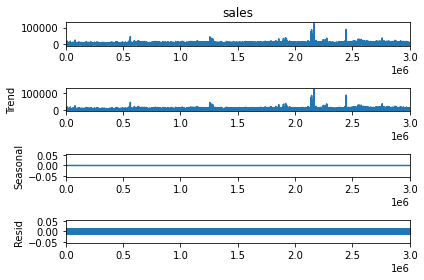

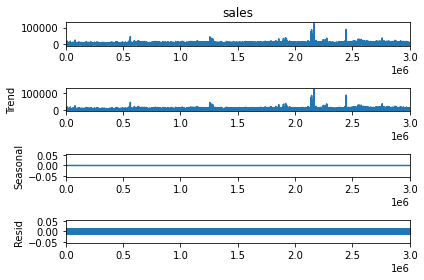

In [80]:
# Checking for trends and seasonality
# Decomposition data
series = df_train["sales"]
result = seasonal_decompose(series, model='additive', period=1)
result.plot()


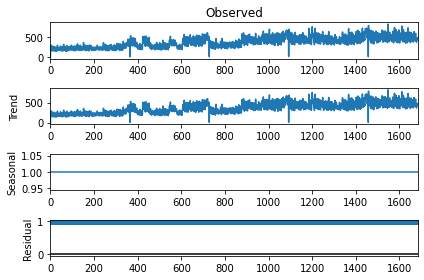

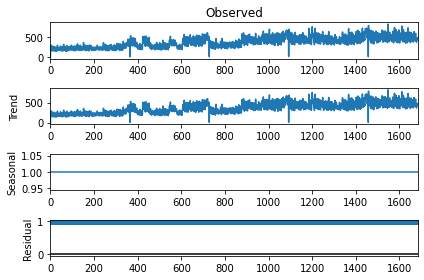

In [81]:
# Checking for trends and seasonality
# Decomposition data
#from statsmodels.tsa.seasonal import seasonal_decompose
series = df_train.groupby(["date"]).mean()["sales"]
series1= np.array(series.values.tolist())
#series = df_train["date"]
result = seasonal_decompose(series1, model='multiplicative', period=1)
result.plot()

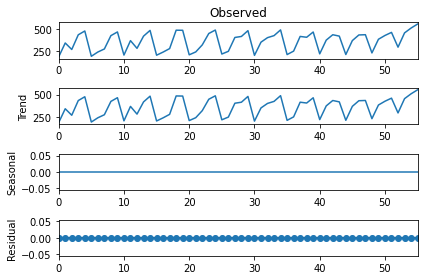

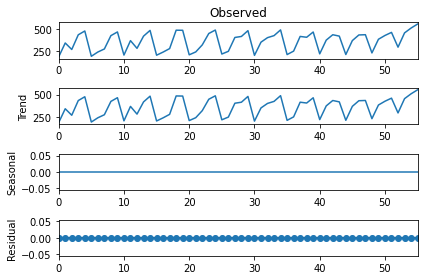

In [82]:
# Checking for trends and seasonality
# Decomposition data
#from statsmodels.tsa.seasonal import seasonal_decompose
series = df_train.groupby(["month", "year"]).mean()["sales"]
series1= np.array(series.values.tolist())
#series = df_train["date"]
result = seasonal_decompose(series1, model='additive', period=1)
result.plot()

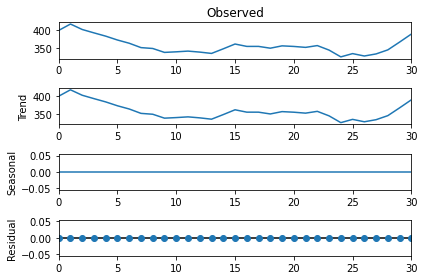

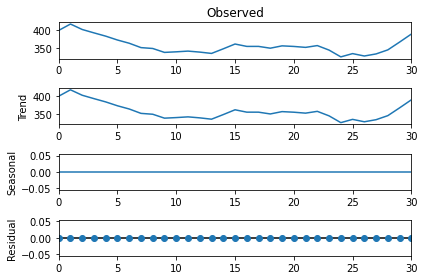

In [83]:
# Checking for trends and seasonality
# Decomposition data
#from statsmodels.tsa.seasonal import seasonal_decompose
series = df_train.groupby(["day"]).mean()["sales"]
series1= np.array(series.values.tolist())
#series = df_train["date"]
result = seasonal_decompose(series1, model='additive', period=1)
result.plot()

**Both multiplicative and additive decomposition shows there is a trend in the data but there is no seasonality

# Feature Creation
We will create features that will help us in training our model. We will be using the sales, day, and ...columns from the df_train dataset and create other features in addition.

In [84]:
df_train

,id,date,store_nbr,family,sales,onpromotion,transactions,city,state,type,cluster,year,month,day,weekday,week,quarter,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.000,0,770.0,Quito,Pichincha,D,13,2013,1,1,1,1,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0,Quito,Pichincha,B,6,2017,8,15,1,33,3,Tuesday


In [85]:
#Creating lags
#df_train['lag_1'] = df_train.groupby("family")['sales'].shift(-1)

#Creating lags
df_train['lag_1'] = df_train['sales'].shift(-1)

In [86]:
#Creating sales for next day
#This might cause data leakage
#df_train['next_day_sales'] = df_train.groupby("family")['sales'].shift(-1)
#Creating sales for next day
df_train['next_day_sales'] = df_train['sales'].shift(-1)

In [87]:
#df_train['sales_diff'] = df_train.groupby("family")['sales'].diff(1)

df_train['sales_diff'] = df_train['sales'].diff(1)

In [88]:
#Rolling statistics
#df_train['mean']=df_train.groupby("family")['sales'].rolling(2).mean().reset_index(level=0, drop=True)
#df_train['median']=df_train.groupby("family")['sales'].rolling(2).median().reset_index(level=0, drop=True)

#Rolling statistics
df_train['mean']=df_train['sales'].rolling(2).mean().reset_index(level=0, drop=True)
df_train['median']=df_train['sales'].rolling(2).median().reset_index(level=0, drop=True)


In [89]:
#One-hot encoding the on promotion column
#a= df_train["onpromotion"]
category= pd.cut(df_train["onpromotion"],bins=[.0,0.9,400,741],labels=["False","True","True"],ordered=False)
df_train.insert(5,"Promotions",category)

#Lets replace the missing values in the sector column with 'undisclosed'
df_train['Promotions'].fillna('False', inplace = True)
df_train

from sklearn.preprocessing import LabelEncoder
promotion_encoder = LabelEncoder()
df_train['Promotions'] = promotion_encoder.fit_transform(df_train['Promotions'])
df_train

,id,date,store_nbr,family,sales,Promotions,onpromotion,transactions,city,state,...,day,weekday,week,quarter,day_of_week,lag_1,next_day_sales,sales_diff,mean,median
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0,770.0,Quito,Pichincha,...,1,1,1,1,Tuesday,0.000,0.000,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,0,770.0,Quito,Pichincha,...,1,1,1,1,Tuesday,0.000,0.000,0.000,0.0000,0.0000
2,2,2013-01-01,1,BEAUTY,0.000,0,0,770.0,Quito,Pichincha,...,1,1,1,1,Tuesday,0.000,0.000,0.000,0.0000,0.0000
3,3,2013-01-01,1,BEVERAGES,0.000,0,0,770.0,Quito,Pichincha,...,1,1,1,1,Tuesday,0.000,0.000,0.000,0.0000,0.0000
4,4,2013-01-01,1,BOOKS,0.000,0,0,770.0,Quito,Pichincha,...,1,1,1,1,Tuesday,0.000,0.000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,0,2155.0,Quito,Pichincha,...,15,1,33,3,Tuesday,154.553,154.553,432.133,222.0665,222.0665
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1,2155.0,Quito,Pichincha,...,15,1,33,3,Tuesday,2419.729,2419.729,-283.580,296.3430,296.3430
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,1,148,2155.0,Quito,Pichincha,...,15,1,33,3,Tuesday,121.000,121.000,2265.176,1287.1410,1287.1410
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,1,8,2155.0,Quito,Pichincha,...,15,1,33,3,Tuesday,16.000,16.000,-2298.729,1270.3645,1270.3645


In [119]:
#df_train['freq'] = df_train['date'].asfreq(freq="M", fill_value= "bfill")

In [120]:
#df_train.tail()

,id,date,store_nbr,family,sales,Promotions,onpromotion,transactions,city,state,...,weekday,week,quarter,day_of_week,lag_1,next_day_sales,sales_diff,mean,median,freq
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,0,2155.0,Quito,Pichincha,...,1,33,3,Tuesday,154.553,154.553,432.133,222.0665,222.0665,NaN
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1,2155.0,Quito,Pichincha,...,1,33,3,Tuesday,2419.729,2419.729,-283.580,296.3430,296.3430,NaN
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,1,148,2155.0,Quito,Pichincha,...,1,33,3,Tuesday,121.000,121.000,2265.176,1287.1410,1287.1410,NaN
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,1,8,2155.0,Quito,Pichincha,...,1,33,3,Tuesday,16.000,16.000,-2298.729,1270.3645,1270.3645,NaN
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,0,2155.0,Quito,Pichincha,...,1,33,3,Tuesday,NaN,NaN,-105.000,68.5000,68.5000,NaN


In [90]:
data =df_train[['date','sales','day','weekday','month','lag_1','next_day_sales','sales_diff','mean','median','Promotions','freq']]

In [91]:
# Dropping missing values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000886 entries, 0 to 3000885
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   sales           float64       
 2   lag_1           float64       
 3   next_day_sales  float64       
 4   sales_diff      float64       
 5   mean            float64       
 6   median          float64       
 7   Promotions      int32         
dtypes: datetime64[ns](1), float64(6), int32(1)
memory usage: 171.7 MB


C:\Users\SISEY\AppData\Local\Temp\ipykernel_17396\1427526036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


# Modeling and Prediction 

In [92]:
data

,date,sales,lag_1,next_day_sales,sales_diff,mean,median,Promotions
0,2013-01-01,0.000,0.000,0.000,0.000,0.0000,0.0000,0
1,2013-01-01,0.000,0.000,0.000,0.000,0.0000,0.0000,0
2,2013-01-01,0.000,0.000,0.000,0.000,0.0000,0.0000,0
3,2013-01-01,0.000,0.000,0.000,0.000,0.0000,0.0000,0
4,2013-01-01,0.000,0.000,0.000,0.000,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...
3000881,2017-08-15,6.000,438.133,438.133,0.000,6.0000,6.0000,0
3000882,2017-08-15,438.133,154.553,154.553,432.133,222.0665,222.0665,0
3000883,2017-08-15,154.553,2419.729,2419.729,-283.580,296.3430,296.3430,1
3000884,2017-08-15,2419.729,121.000,121.000,2265.176,1287.1410,1287.1410,1


<AxesSubplot:>

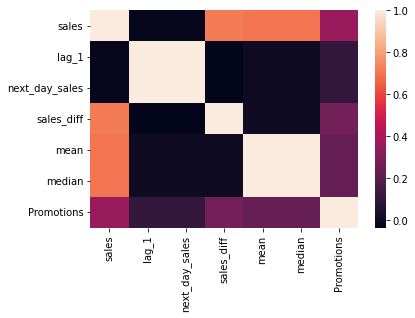

In [93]:
sns.heatmap(data.corr())

In [94]:
#Train.shape, valid.shape
#train_data = data.loc[~(data["date"].isin([2017]) & data["date"].isin([10,11,12]))]
#val_data = data.loc[(data["date"].isin([2017]) & data["date"].isin([10,11,12]))]
#val_data.tail()
#val_data.tail()

In [95]:
#Split data into train and validation data
#data['date'].min(), data['date'].max(), (data['date'].max() -data['date'].min())

data.index = pd.to_datetime(data['date'])

train1=data.loc['2013-01-01':'2017-06-30'] 
valid=data.loc['2017-07-01':'2017-08-15']

train1.shape, valid.shape
valid.head()

,date,sales,lag_1,next_day_sales,sales_diff,mean,median,Promotions
date,,,,,,,,
2017-07-01,2017-07-01,7.0,0.000,0.000,-15.438,14.719,14.719,0
2017-07-01,2017-07-01,0.0,7.000,7.000,-7.000,3.500,3.500,0
2017-07-01,2017-07-01,7.0,2596.000,2596.000,7.000,3.500,3.500,1
2017-07-01,2017-07-01,2596.0,0.000,0.000,2589.000,1301.500,1301.500,1
2017-07-01,2017-07-01,0.0,344.722,344.722,-2596.000,1298.000,1298.000,0


In [96]:

X_train =train1.drop(columns=["sales","date"])
#y_train =train1.drop(columns=["date","lag_1","next_day_sales","sales_diff","mean","date"])
#y_train =y_train.drop(columns=["date"])
y_train=train1["sales"]
y_train

date
2013-01-01       0.000
2013-01-01       0.000
2013-01-01       0.000
2013-01-01       0.000
2013-01-01       0.000
                ...   
2017-06-30     561.609
2017-06-30     113.306
2017-06-30    1522.438
2017-06-30       0.000
2017-06-30      22.438
Name: sales, Length: 2918915, dtype: float64

In [97]:
#Encoding data
label_encoder= preprocessing.LabelEncoder()
y_train= label_encoder.fit_transform(y_train)

In [98]:
#rfm = RandomForestClassifier()
#rfm.fit(X_train, y_train1)
rfm =RandomForestRegressor(n_estimators=100,max_depth=6,n_jobs=3, random_state=0)
rfm.fit(X_train, y_train)


RandomForestRegressor(max_depth=6, n_jobs=3, random_state=0)

In [99]:
#Training the Model
#from sklearn.preprocessing import StandardScaler
#features =["mean","lag_1","next_day_sales","sales_diff"]
#imputer = SimpleImputer()
#Xtr= imputer.fit_transform(data[features])
#ytr=data["sales"]
#Xtr =data.drop(columns=["sales","date"])
#ytr=data["sales"]
#rfm =RandomForestRegressor(n_estimators=100,max_depth=6,n_jobs=3, random_state=0)
#rfm.fit(Xtr, ytr)


In [100]:

X_test =valid.drop(columns=["sales","date"])
#y_train =train1.drop(columns=["date","lag_1","next_day_sales","sales_diff","mean","date"])
#y_train =y_train.drop(columns=["date"])
y_test=valid["sales"]
y_test

date
2017-07-01       7.000
2017-07-01       0.000
2017-07-01       7.000
2017-07-01    2596.000
2017-07-01       0.000
                ...   
2017-08-15       6.000
2017-08-15     438.133
2017-08-15     154.553
2017-08-15    2419.729
2017-08-15     121.000
Name: sales, Length: 81971, dtype: float64

# Evaluation

In [101]:
#Prediction
pred= rfm.predict(X_test)
mae = mean_absolute_error(y_test, pred)
msrle = mean_squared_log_error(y_test, d_y_pred))
mae,msrle

91543.16741715997

In [102]:
from math import sqrt
RMS = sqrt(mean_squared_error(y_test, pred))
RMS

146062.8593822456

In [103]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
rfm = RandomForestRegressor(n_estimators=20,max_depth=6,random_state=0)
rfm.fit(X_train, y_train)
y_pred = rfm.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Log Error:', mean_squared_log_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 91554.60015280412
Mean Squared Error: 21348578314.04583
Root Mean Squared Error: 146111.5269718506


In [109]:
dtm = DecisionTreeRegressor(random_state=150)
dtm.fit(X_train, y_train)
d_y_pred = dtm.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, d_y_pred))
print('Mean Squared Log Error:', mean_squared_log_error(y_test, d_y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, d_y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, d_y_pred)))


Mean Absolute Error: 89084.28173370329
Mean Squared Error: 21716769650.834324
Root Mean Squared Error: 147366.10753777248


In [111]:
mean_squared_log_error(y_test, y_pred)
mean_squared_log_error(y_test, d_y_pred)

28.453134443682984

In [ ]:
sns.heatmap(df_train.corr())